In [38]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
os.getcwd()

'/Users/tarunvinodhkumar/Downloads/Spark-Movie-Recommendation-master'

In [39]:
movies = spark.read.load("/Users/tarunvinodhkumar/Downloads/Spark-Movie-Recommendation-master/ml-latest-small/movies.csv", format='csv', header = True)
ratings = spark.read.load("/Users/tarunvinodhkumar/Downloads/Spark-Movie-Recommendation-master/ml-latest-small/ratings.csv", format='csv', header = True)
links = spark.read.load("/Users/tarunvinodhkumar/Downloads/Spark-Movie-Recommendation-master/ml-latest-small/links.csv", format='csv', header = True)
tags = spark.read.load("/Users/tarunvinodhkumar/Downloads/Spark-Movie-Recommendation-master/ml-latest-small/tags.csv", format='csv', header = True)

In [40]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [41]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [42]:
links.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [43]:
tags.show(5)

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
|    15|   1955|             dentist|1193435061|
|    15|   7478|            Cambodia|1170560997|
|    15|  32892|             Russian|1170626366|
|    15|  34162|         forgettable|1141391765|
+------+-------+--------------------+----------+
only showing top 5 rows



In [44]:
movies.groupby("genres").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              genres|count|
+--------------------+-----+
|               Drama| 1170|
|              Comedy|  809|
|        Comedy|Drama|  425|
|         Documentary|  365|
|       Drama|Romance|  356|
|      Comedy|Romance|  341|
|Comedy|Drama|Romance|  264|
|              Horror|  183|
|      Drama|Thriller|  172|
|         Crime|Drama|  135|
|Crime|Drama|Thriller|  116|
|     Horror|Thriller|  112|
|           Drama|War|  107|
|        Comedy|Crime|   77|
|            Thriller|   74|
|       Action|Comedy|   67|
|     Children|Comedy|   64|
|       Comedy|Horror|   57|
|     Action|Thriller|   57|
|        Action|Drama|   53|
+--------------------+-----+
only showing top 20 rows



In [45]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']


In [46]:
tmp1 = ratings.groupBy("userID").count().select('count').rdd.min()[0]
tmp2 = ratings.groupBy("movieId").count().select('count').rdd.min()[0]
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [47]:
tmp1 = ratings.groupBy("movieId").count().withColumnRenamed("count", "rating count")\
.groupBy("rating count").count().orderBy('rating count').first()[1]
# Or use pandas: tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3063 out of 9066 movies are rated by only one user


In [48]:
print("Number of users:", ratings.select('userId').union(tags.select('userId')).distinct().count())

Number of users: 671


In [49]:
print("Number of users who rated movies:", ratings.select('userId').distinct().count())

Number of users who rated movies: 671


In [50]:
print("Number of movies:", ratings.select('movieId').union(tags.select('movieId')).distinct().count())

Number of movies: 9125


In [51]:
print("Number of rated movies:", ratings.select('movieId').distinct().count())

Number of rated movies: 9066


In [52]:
ratings = ratings.select("userId", "movieId", "rating")

In [53]:
# inspect the schema of the data frame
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)



In [54]:

df = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))

In [55]:
# inspect the schema again
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



In [56]:
train, validation, test = df.randomSplit([0.6,0.2,0.2], seed = 0)

In [57]:
print("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 59946, 19886, 20172


In [58]:
mean_rating = train.groupby('movieId').mean().select('movieId','avg(rating)')
mean_rating = mean_rating.withColumnRenamed('avg(rating)','prediction')
mean_rating.show(5)

+-------+------------------+
|movieId|        prediction|
+-------+------------------+
|   1580|3.6359649122807016|
|   1088| 3.303030303030303|
|   1342| 2.923076923076923|
|   1645|3.3658536585365852|
|   3175|3.4886363636363638|
+-------+------------------+
only showing top 5 rows



In [59]:
test.createOrReplaceTempView("test")
mean_rating.createOrReplaceTempView("mean_rating")

sqlDF = spark.sql("select test.*, mean_rating.prediction \
                   from test join mean_rating \
                   on test.movieId = mean_rating.movieId")
sqlDF.show(5)

+------+-------+------+------------------+
|userId|movieId|rating|        prediction|
+------+-------+------+------------------+
|   665|   1580|   4.0|3.6359649122807016|
|   646|   1580|   5.0|3.6359649122807016|
|   627|   1580|   3.0|3.6359649122807016|
|   585|   1580|   3.0|3.6359649122807016|
|   582|   1580|   4.0|3.6359649122807016|
+------+-------+------+------------------+
only showing top 5 rows



In [60]:
# Define a function to calculate RMSE

from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [61]:
print('Using the mean rating of each movie as the prediction, the testing RMSE is ' + str(RMSE(sqlDF)))

Using the mean rating of each movie as the prediction, the testing RMSE is 1.00224677222886


In [63]:
# Define a function to perform grid search and find the best ALS model
# based on the validation RMSE

from pyspark.ml.recommendation import ALS

def GridSearch(train, valid, num_iterations, reg_param, n_factors):
    min_rmse = float('inf')
    best_n = -1
    best_reg = 0
    best_model = None
    for n in n_factors:
        for reg in reg_param:
            als = ALS(rank = n, 
                      maxIter = num_iterations, 
                      seed = 0, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop")            
            model = als.fit(train)
            predictions = model.transform(valid)
            rmse = RMSE(predictions)     
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(n, reg, rmse))
            if rmse < min_rmse:
                min_rmse = rmse
                best_n = n
                best_reg = reg
                best_model = model
                
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    print('\nThe best model has {} latent factors and regularization = {}:'.format(best_n, best_reg))
    print('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    return best_model

In [64]:
num_iterations = 10
ranks = [6, 8, 10, 12]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

start_time = time.time()
final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)
print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 1.011383695732926
6 latent factors and regularization = 0.1: validation RMSE is 0.944433391718441
6 latent factors and regularization = 0.2: validation RMSE is 0.9219127806852144
6 latent factors and regularization = 0.4: validation RMSE is 0.9862438343613906
6 latent factors and regularization = 0.8: validation RMSE is 1.2007007981379596


8 latent factors and regularization = 0.05: validation RMSE is 1.0322550274213618
8 latent factors and regularization = 0.1: validation RMSE is 0.9505625170615337
8 latent factors and regularization = 0.2: validation RMSE is 0.9240487593215392
8 latent factors and regularization = 0.4: validation RMSE is 0.9870599211241223
8 latent factors and regularization = 0.8: validation RMSE is 1.2007030095840674


10 latent factors and regularization = 0.05: validation RMSE is 1.0368626439244146
10 latent factors and regularization = 0.1: validation RMSE is 0.9498351391074188
10 latent factors and regularization = 0.2: validation RMSE is 0.9220222255007756
10 latent factors and regularization = 0.4: validation RMSE is 0.9861598867921292
10 latent factors and regularization = 0.8: validation RMSE is 1.2006984599700519
12 latent factors and regularization = 0.05: validation RMSE is 1.048354922590958


12 latent factors and regularization = 0.1: validation RMSE is 0.9474691290942935
12 latent factors and regularization = 0.2: validation RMSE is 0.9229637969186764
12 latent factors and regularization = 0.4: validation RMSE is 0.9871099494253439
12 latent factors and regularization = 0.8: validation RMSE is 1.2007003100412406

The best model has 6 latent factors and regularization = 0.2:
traning RMSE is 0.7045018939245088; validation RMSE is 0.9219127806852144
Total Runtime: 49.52 seconds


In [65]:
num_iterations = 15
ranks = [7, 8, 9]
reg_params = [0.1, 0.2, 0.3]

final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)

7 latent factors and regularization = 0.1: validation RMSE is 0.9475924275003726


7 latent factors and regularization = 0.2: validation RMSE is 0.9225546379507011
7 latent factors and regularization = 0.3: validation RMSE is 0.9467000499909671
8 latent factors and regularization = 0.1: validation RMSE is 0.9473442287484947
8 latent factors and regularization = 0.2: validation RMSE is 0.9231712068425756
8 latent factors and regularization = 0.3: validation RMSE is 0.9474268052292185
9 latent factors and regularization = 0.1: validation RMSE is 0.9459107732558373
9 latent factors and regularization = 0.2: validation RMSE is 0.9222952594522511
9 latent factors and regularization = 0.3: validation RMSE is 0.9467546282136293

The best model has 9 latent factors and regularization = 0.2:
traning RMSE is 0.6825498984879187; validation RMSE is 0.9222952594522511


In [67]:
pred_test = final_model.transform(test)
print('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.9262997814932259


## Visualization


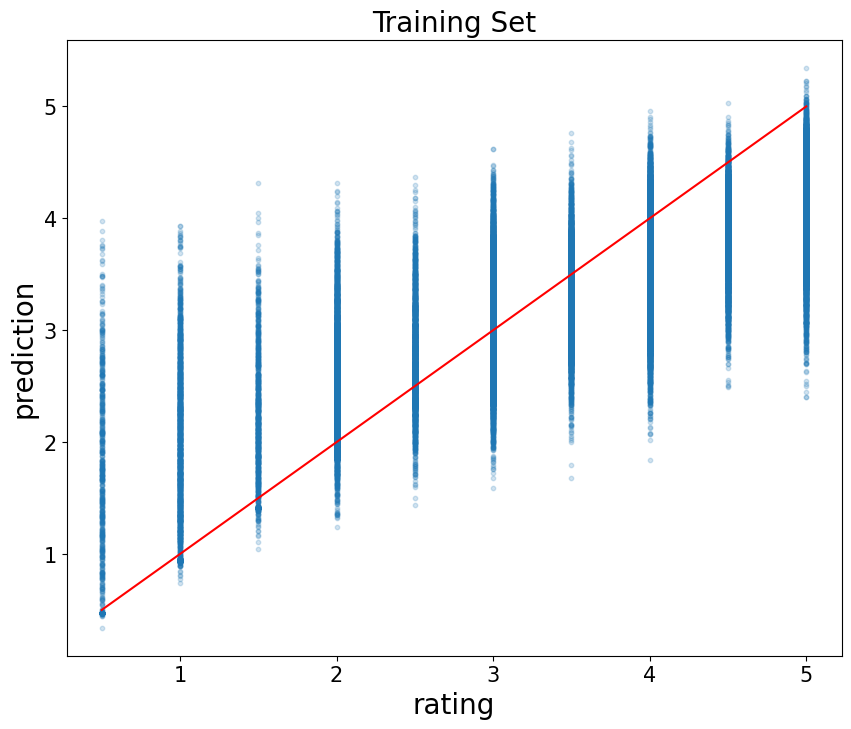

In [68]:
pred_train = final_model.transform(train)
df = pred_train.toPandas()
x = np.arange(0.5, 5.1, 0.5) # To draw the red one-to-one line below

fig = plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)
plt.scatter(df.rating, df.prediction, s = 10, alpha = 0.2)
plt.plot(x, x, c = 'r')
plt.xlabel('rating', fontsize=20)
plt.ylabel('prediction', fontsize=20)
plt.title('Training Set', fontsize=20)
plt.show()

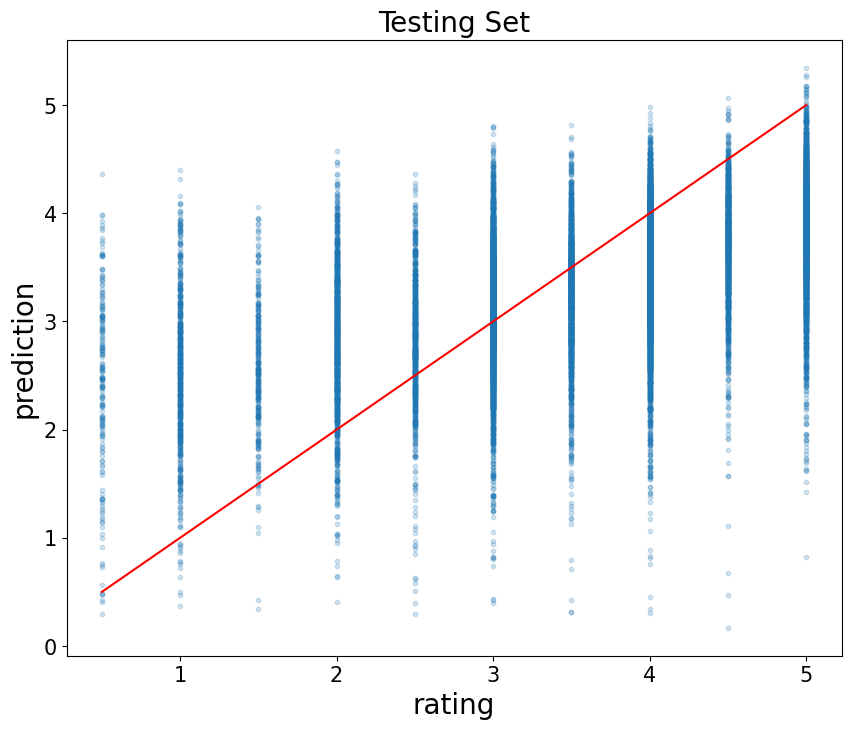

In [69]:
df = pred_test.toPandas()
fig = plt.figure(figsize=(10,8))
plt.tick_params(labelsize=15)
plt.scatter(df.rating, df.prediction, s = 10, alpha = 0.2)
plt.plot(x, x, c = 'r')
plt.xlabel('rating', fontsize=20)
plt.ylabel('prediction', fontsize=20)
plt.title('Testing Set', fontsize=20)
plt.show()